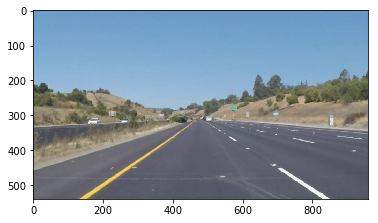

(540, 960, 3)


In [253]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
# image = mpimg.imread('./assets/exit-ramp.jpg')
img = 'c2_f437.jpg'
image = mpimg.imread('./CarND-LaneLines-P1/challenge_images/{}'.format(img))

# image = mpimg.imread('./CarND-LaneLines-P1/test_images/solidWhiteRight.jpg')

plt.imshow(image)
plt.show()
print(image.shape)

In [254]:
def get_color_mask(img, target_color, eps):
    mask = np.zeros()

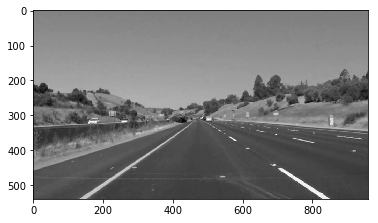

In [255]:
import cv2
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')
plt.show()

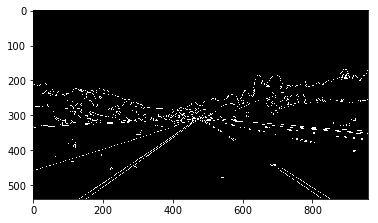

In [256]:
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.show()

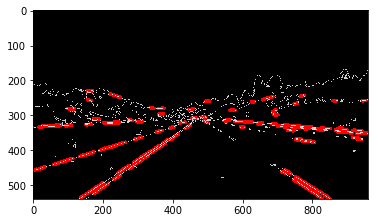

In [257]:
import numpy as np

rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1
line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)
plt.show()

viridis
[0.267004, 0.004874, 0.329415]


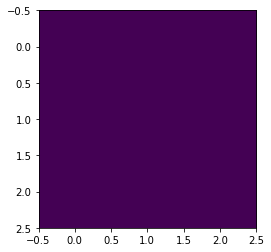

In [258]:
import matplotlib
from matplotlib import cm
print (matplotlib.rcParams['image.cmap'])
x = cm.get_cmap(name = 'viridis')
print(x.colors[0])
y = np.zeros([3,3,3], dtype=np.float32)
for i in range(3):
    for j in range(3):
        y[i,j,:] = x.colors[0]

plt.figure()
_=plt.imshow(y)           

In [265]:
def get_yrange(img_shape):
    """
    Get y-range for the region of interest: we keep 30%-bottom image
    """
    y_top    = int(img_shape[0] * 0.6)
    y_bottom = int(img_shape[0] * 0.9)
    return y_bottom, y_top

def get_xrange_left(img_shape):
    """
    Get x-range for the quadrilateral
    """
    x_bottom_left_left  = img_shape[1]*0.1575 #0.05
    x_bottom_left_right = img_shape[1]*0.35    #0.35 
    x_top_left_left     = img_shape[1]*0.48
    x_top_left_right    = img_shape[1]*0.50
    
    return x_bottom_left_left, x_bottom_left_right, x_top_left_left, x_top_left_right

def get_xrange_right(img_shape):
    x_bottom_right_left  = img_shape[1]*0.65    #0.65
    x_bottom_right_right = img_shape[1]*0.8425 #0.95 #
    x_top_right_left     = img_shape[1]*0.50
    x_top_right_right    = img_shape[1]*0.52
    
    return x_bottom_right_left, x_bottom_right_right, x_top_right_left, x_top_right_right

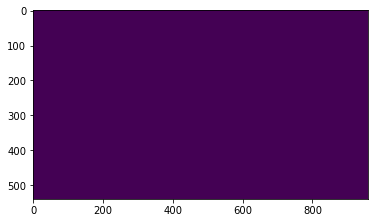

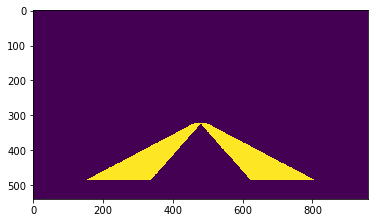

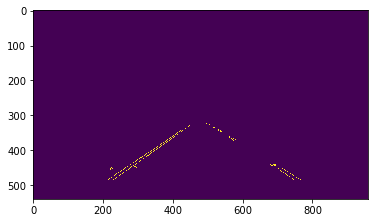

In [266]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges) 
ignore_mask_color = 255 
plt.figure()
plt.imshow(mask)           

imshape = image.shape
y_bottom, y_top = get_yrange(imshape)

for section in ['left', 'right']:
    if section == 'left':
        x_bottom_left, x_bottom_right, x_top_left, x_top_right = get_xrange_left(imshape)            
    else:
        x_bottom_left, x_bottom_right, x_top_left, x_top_right = get_xrange_right(imshape)            

    vertices = np.array([[(x_bottom_left, y_bottom),
                          (x_top_left,    y_top), 
                          (x_top_right,   y_top), 
                          (x_bottom_right, y_bottom)]], dtype=np.int32)

    cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_edges = cv2.bitwise_and(edges, mask)

plt.figure()
plt.imshow(mask)
plt.figure()
_=plt.imshow(masked_edges)

In [261]:
def fit_ignore_outline(x, y, threshold = 2.0):
    fit = np.polyfit(x, y, 1)
    errs = y - x * fit[0] - fit[1]
    mean = np.mean(errs)
    sig  = np.sqrt(np.var(errs))
    idx = np.where((errs < mean + threshold * sig) & (errs > mean - threshold * sig) )[0]
    return np.polyfit(x[idx], y[idx], 1)
    

[ 0.62749094  9.13033732]
486
325
759


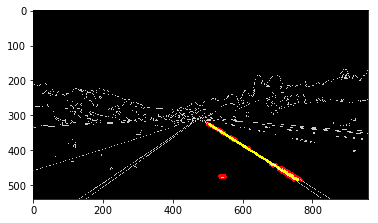

In [262]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
x_left = []
y_left = []
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        x_left += [x1, x2]
        y_left += [y1, y2]

fit = fit_ignore_outline(np.array(x_left), np.array(y_left))
print(fit)
max_y = np.max(y_left)
min_y = np.min(y_left)
print(max_y)
print(min_y)
max_x = int((max_y - fit[1])/fit[0])
min_x = int((min_y - fit[1])/fit[0])
print(max_x)

cv2.line(line_image, (max_x, max_y), (min_x, min_y), [255,255,0], 5)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.figure()
plt.imshow(lines_edges)
plt.show()

In [263]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_yrange(img_shape):
    """
    Get y-range for the region of interest: we keep 30%-bottom image
    """
    y_top    = int(img_shape[0] * 0.6)
    y_bottom = int(img_shape[0] * 0.9)
    return y_bottom, y_top

def get_xrange_left(img_shape):
    """
    Get x-range for the quadrilateral
    """
    x_bottom_left_left  = img_shape[1]*0.1575 #0.05
    x_bottom_left_right = img_shape[1]*0.5    #0.35 
    x_top_left_left     = img_shape[1]*0.48
    x_top_left_right    = img_shape[1]*0.50
    
    return x_bottom_left_left, x_bottom_left_right, x_top_left_left, x_top_left_right

def get_xrange_right(img_shape):
    x_bottom_right_left  = img_shape[1]*0.5    #0.65
    x_bottom_right_right = img_shape[1]*0.8425 #0.95 #
    x_top_right_left     = img_shape[1]*0.50
    x_top_right_right    = img_shape[1]*0.52
    
    return x_bottom_right_left, x_bottom_right_right, x_top_right_left, x_top_right_right

def fit_ignore_outline(x, y, threshold = 2.0):
    """
    Fit while ignoring some outline points is done by following steps:
        1) First, we do one fit, next we compute the fitted errors 
        2) Then we compute mean m and stddev sig of the errors 
        3) We keep all samples that has fitted error in the range of [m - threshold*sig, m + threshold*sig]
    
    Finally we re-fit with these samples.
    """
    fit = np.polyfit(x, y, 1)
    errs = y - x * fit[0] - fit[1]
    mean = np.mean(errs)
    sig  = np.sqrt(np.var(errs))
    idx = np.where((errs < mean + threshold * sig) & (errs > mean - threshold * sig) )[0]
    return np.polyfit(x[idx], y[idx], 1)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_solid_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function will draw a solid line from input lines
    The input lines must be lines only from left or right
    
    We will do linear fit to get a single line from all input lines
    Note that, we also filter out some outline using function
            fit_ignore_outline
    """
    max_y, min_y = get_yrange(img.shape)
    max_y = img.shape[0] # entend to camera
    
    x = []
    y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            x += [x1, x2]
            y += [y1,y2]
    
    
    fit = fit_ignore_outline(np.array(x), np.array(y))
    
    max_x = int((max_y - fit[1])/fit[0])
    min_x = int((min_y - fit[1])/fit[0])
        
        
    cv2.line(img, (min_x, min_y), (max_x, max_y), color, thickness)
    return fit
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness = 5)
    return line_img

def hough_solid_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform (but only left-lane or right-lane).
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    fit = draw_solid_lines(line_img, lines, thickness = 5)
    return line_img, fit

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def lane_finding(img):
    # first we convert img to grayscale
    img_gray = grayscale(img)
    
    # apply Guassian smoothing
    blur_ksize = 3
    blur_gray = gaussian_blur(img_gray, kernel_size=blur_ksize)
    
    # extract Canny edges (using parameters from course)
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # get zones of interest
    imshape = img.shape
    y_bottom, y_top = get_yrange(imshape)
    
    lanes = []
    fits = []
    for section in ['left', 'right']:
        if section == 'left':
            x_bottom_left, x_bottom_right, x_top_left, x_top_right = get_xrange_left(imshape)            
        else:
            x_bottom_left, x_bottom_right, x_top_left, x_top_right = get_xrange_right(imshape)            
        
        vertices = np.array([[(x_bottom_left, y_bottom),
                              (x_top_left,    y_top), 
                              (x_top_right,   y_top), 
                              (x_bottom_right, y_bottom)]], dtype=np.int32)
        masked_img = region_of_interest(edges, vertices)
    
        rho = 1             # distance resolution in pixels of the Hough grid
        theta = np.pi/180   # angular resolution in radians of the Hough grid
        threshold = 1       # minimum number of votes (intersections in Hough grid cell)
        min_line_len = 5    # minimum number of pixels making up a line
        max_line_gap = 10    # maximum gap in pixels between connectable line segments
    
        # draw line_finding layer
        lf_layer,fit = hough_solid_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
        fits.append(fit)
        lanes.append(lf_layer)
    
    img_out = np.copy(img)
    for lf in lanes:
        img_out = weighted_img(lf, img_out)
    
    return img_out, fits

[array([  -0.68654055,  637.15202033]), array([ 0.62749094,  9.13033732])]


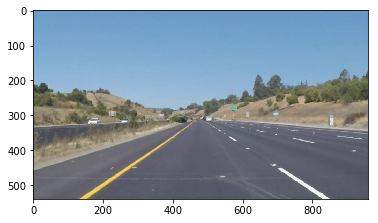

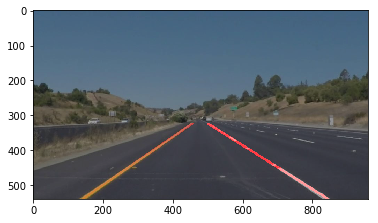

In [264]:
img, fits = lane_finding(image)
plt.imshow(image)
plt.figure()
plt.imshow(img)
print(fits)